Part 2 - Q3 - Visualization
===



# Preliminaries

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
%matplotlib inline

In [12]:
import param
import panel as pn
pn.extension()
import datetime as dt
import importlib
from importlib import reload

In [14]:
import graph as gr
import params as par
import py_lib as lib
reload(gr)
reload(par)
reload(lib)
import graph as gr
import params as par
import py_lib as lib

In [15]:
format_dict = par.create_format_dict()

In [16]:
class NotebookParams(param.Parameterized):
    lambda_multiple          = param.Number(1, bounds=(1,10), doc="lambda Lasso Multiple of 10^x")
    lambda_power             = param.Integer(default=2, bounds=(1,7),doc="lambda Lasso exponent of 10^x")
    lr_multiple              = param.Number(5, bounds=(1,10), doc="Learning Rate Multiple of 10^x")
    lr_power                 = param.Integer(default=3, bounds=(1,9),doc="Learning Rate exponent of 10^x")
    epochs                   = param.Integer(default=2000 ,bounds=(1,2000))
    data_set                 = param.ObjectSelector(default="test",objects=['train', 'validation', 'train + validation', 'test'])
    stand_features           = param.Boolean(False, doc="Whether we want to standardize numerical features")
    use_lasso                = param.Boolean(True)
    use_focal_loss           = param.Boolean(True)
    iter_array               = param.Integer(default=5, bounds=(1,20),doc="How often to save loss and training data, in epochs")
    iter_printing            = param.Integer(default=5, bounds=(1,100),doc="How many epochs between printing")
    add_one_hot_encoded      = param.Boolean(False, doc="Whether to add one hot encoded columns from categorical variables")
    test_size                = param.Number(0.2, bounds=(0.1,0.9), doc="Test size for train_test_split")
    random_state_test_train_split = param.Integer(42)
base = NotebookParams()

## ML Preliminaries

In [27]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score, balanced_accuracy_score
from tensorflow.keras.models import load_model

In [28]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc

In [29]:
import torch
import torch.nn.functional as F

In [30]:
import tensorflow as tf
from tensorflow.keras import backend as K
from keras.optimizers import  SGD
from keras.optimizers import  RMSprop
from keras.optimizers import Adam

def focal_loss(gamma=2., alpha=0.25):
    def focal_loss_fixed(y_true, y_pred):
        epsilon = K.epsilon()
        y_pred = K.clip(y_pred, epsilon, 1. - epsilon)
        y_true = tf.cast(y_true, tf.float32)
        
        alpha_t = y_true * alpha + (K.ones_like(y_true) - y_true) * (1 - alpha)
        p_t = y_true * y_pred + (K.ones_like(y_true) - y_true) * (1 - y_pred)
        fl = - alpha_t * K.pow((K.ones_like(y_true) - p_t), gamma) * K.log(p_t)
        
        return K.mean(fl)
    return focal_loss_fixed

In [31]:
from keras.callbacks import ReduceLROnPlateau
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.3, min_lr=0.000001)

## Import Encoders

In [32]:
# Load the pre-trained encoder
encoder_model_question_1 = load_model('model_log_v2.keras', custom_objects={'focal_loss_fixed': focal_loss})

/home/pinolej/.venv_2/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:418: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 10 variables whereas the saved optimizer has 18 variables. 
  trackable.load_own_variables(weights_store.get(inner_path))


In [33]:
# Load the pre-trained encoder
encoder_model_question_2 = load_model('encoder_2.keras')

# Dataset 1/ MIT BIH

## Data Preliminaries

### Import Data

In [90]:
df_heart_test = pd.read_csv('../data_proj2/mitbih_test.csv', header=None)
df_heart_train = pd.read_csv('../data_proj2/mitbih_train.csv', header=None)

In [91]:
df_heart_train.head(3)

,0,1,2,3,4,5,6,7,8,9,...,178,179,180,181,182,183,184,185,186,187
0,0.977941,0.926471,0.681373,0.245098,0.154412,0.191176,0.151961,0.085784,0.058824,0.049020,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.960114,0.863248,0.461538,0.196581,0.094017,0.125356,0.099715,0.088319,0.074074,0.082621,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.000000,0.659459,0.186486,0.070270,0.070270,0.059459,0.056757,0.043243,0.054054,0.045946,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [92]:
df_heart_train.shape

(87554, 188)

### Labels

In [93]:
label_col = list(df_heart_train.columns)[-1]
labels_count = df_heart_train[label_col].value_counts(normalize=True).to_frame().T
labels_count.columns = [str(x) for x in labels_count.columns]
n_classes = len(labels_count.columns)
labels_values = df_heart_train[label_col]
labels_count.style.format(format_dict)

,0.0,4.0,2.0,1.0,3.0
proportion,83%,7%,7%,3%,1%


In [94]:
n_classes

5

/home/pinolej/eth/healthcare/proj3/task_1/graph.py:146: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


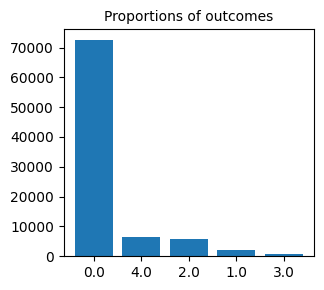

In [95]:
gr.dist_mult_plots(
    df_heart_train,
    cols=[label_col],
		rename_cols_for_title={label_col: 'Proportions of outcomes'},
    figsize=(6, 3),
    ncols=2,
    bar_plot=True,
    fontsize={
        'ax_title': 10,
    },
)

### Features pre-processing

In [96]:
x_train_0, _, y_train_0, _ = lib.pre_process_ecg(
        df_heart_train,
        label_col_pos=-1,
        test_size=base.test_size,
        random_state=base.random_state_test_train_split,
        split_data=False,
				with_lstm_transfo=False,
				for_keras=True,
				n_classes=n_classes,
)

## Visualizations of encoder question 1 representations

You can change the encoder choice in the below cell. The section will run on the encoder selected in the next cell.

In [97]:
encoder = encoder_model_question_1

In [98]:
# Assuming you have already loaded your pre-trained encoder and data
encoded_data = encoder.predict(x_train_0)

 352/2737 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step

2737/2737 ━━━━━━━━━━━━━━━━━━━━ 13s 5ms/step


In [99]:
# t-SNE
from sklearn.manifold import TSNE

# Initialize t-SNE
tsne = TSNE(n_components=2, random_state=42)

# Fit and transform the data
tsne_results = tsne.fit_transform(encoded_data)

In [100]:
# Umap
import umap.umap_ as umap

# Initialize UMAP
umap_reducer = umap.UMAP(n_components=2, random_state=42)

# Fit and transform the data
umap_results = umap_reducer.fit_transform(encoded_data)

/home/pinolej/.venv_2/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


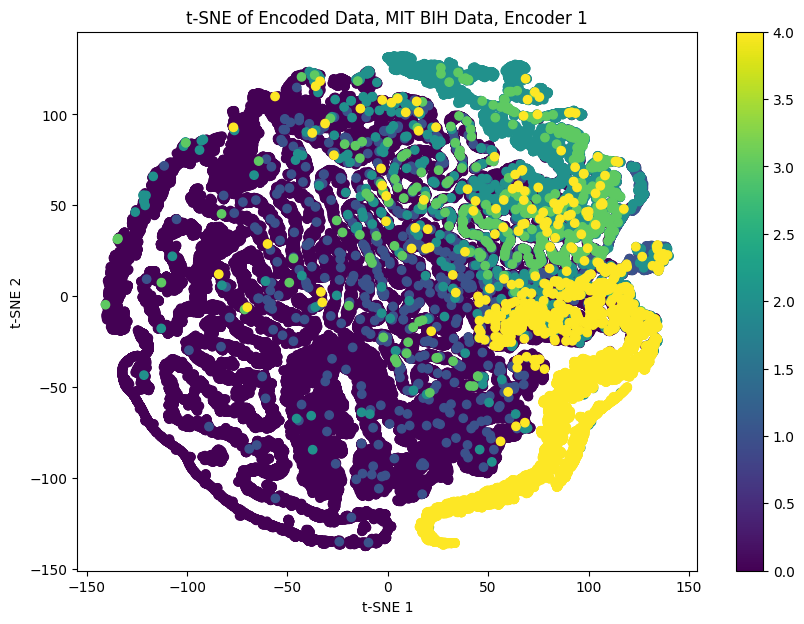

In [101]:
# For t-SNE results
plt.figure(figsize=(10, 7))
plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=labels_values, cmap='viridis') # labels is your data labels if available
plt.colorbar()
plt.title('t-SNE of Encoded Data, MIT BIH Data, Encoder 1')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.show()

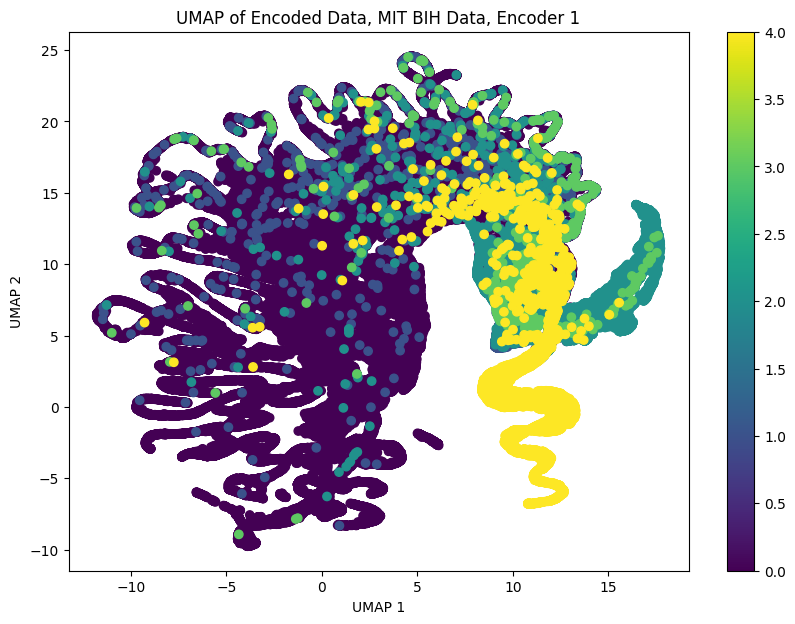

In [102]:
# For UMAP results
plt.figure(figsize=(10, 7))
plt.scatter(umap_results[:, 0], umap_results[:, 1], c=labels_values, cmap='viridis') # labels is your data labels if available
plt.colorbar()
plt.title('UMAP of Encoded Data, MIT BIH Data, Encoder 1')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.show()

## Visualizations of encoder question 2 representations

You can change the encoder choice in the below cell. The section will run on the encoder selected in the next cell.

In [103]:
encoder = encoder_model_question_2

In [104]:
# Assuming you have already loaded your pre-trained encoder and data
encoded_data = encoder.predict(x_train_0)

2737/2737 ━━━━━━━━━━━━━━━━━━━━ 31s 11ms/step


In [105]:
# t-SNE
from sklearn.manifold import TSNE

# Initialize t-SNE
tsne = TSNE(n_components=2, random_state=42)

# Fit and transform the data
tsne_results = tsne.fit_transform(encoded_data)

In [106]:
# Umap
import umap.umap_ as umap

# Initialize UMAP
umap_reducer = umap.UMAP(n_components=2, random_state=42)

# Fit and transform the data
umap_results = umap_reducer.fit_transform(encoded_data)

/home/pinolej/.venv_2/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


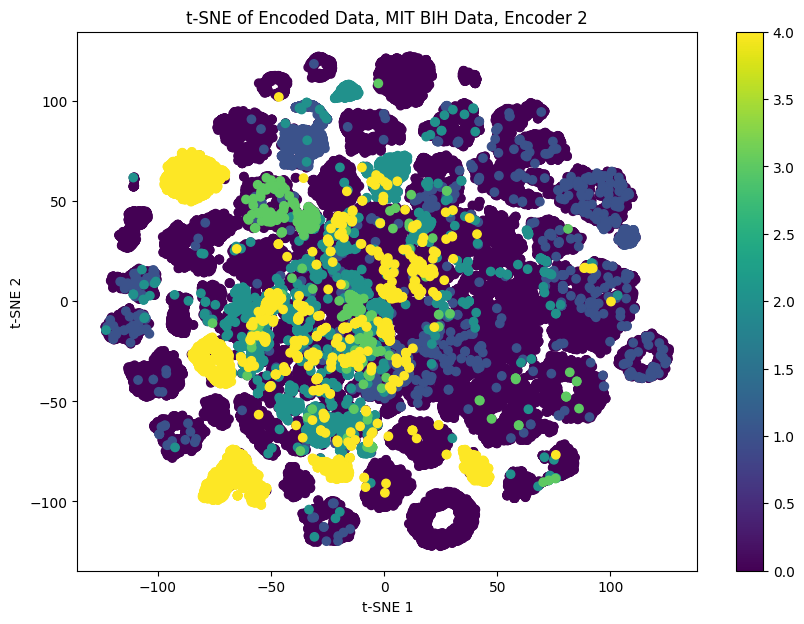

In [107]:
# For t-SNE results
plt.figure(figsize=(10, 7))
plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=labels_values, cmap='viridis') # labels is your data labels if available
plt.colorbar()
plt.title('t-SNE of Encoded Data, MIT BIH Data, Encoder 2')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.show()

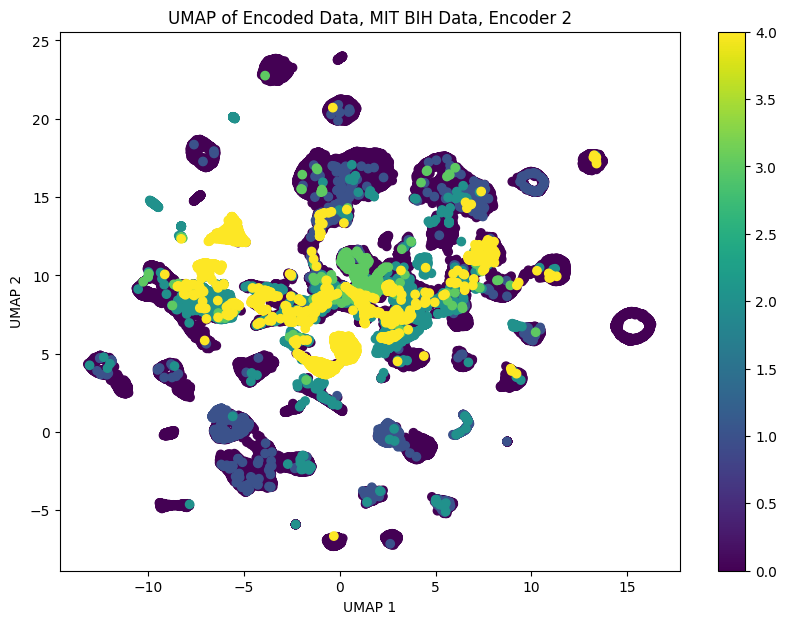

: 

In [108]:
# For UMAP results
plt.figure(figsize=(10, 7))
plt.scatter(umap_results[:, 0], umap_results[:, 1], c=labels_values, cmap='viridis') # labels is your data labels if available
plt.colorbar()
plt.title('UMAP of Encoded Data, MIT BIH Data, Encoder 2')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.show()

# Dataset 2/ PTB

## Data Preliminaries

### Import Data

In [54]:
df_heart_test = pd.read_csv('../data_proj2/ptbdb_test.csv', header=None)
df_heart_train = pd.read_csv('../data_proj2/ptbdb_train.csv', header=None)

In [55]:
df_heart_train.head(3)

,0,1,2,3,4,5,6,7,8,9,...,178,179,180,181,182,183,184,185,186,187
0,1.000000,0.730599,0.472859,0.139526,0.000000,0.020507,0.112183,0.162847,0.180941,0.192199,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,1.000000,0.152446,0.011377,0.308305,0.153584,0.096701,0.083049,0.086462,0.105802,0.071672,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.975917,0.693234,0.241399,0.107225,0.098050,0.072248,0.062500,0.054472,0.054472,0.045872,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [56]:
df_heart_train.shape

(11641, 188)

### Labels

In [57]:
label_col = list(df_heart_train.columns)[-1]
labels_count = df_heart_train[label_col].value_counts(normalize=True).to_frame().T
labels_count.columns = [str(x) for x in labels_count.columns]
n_classes = len(labels_count.columns)
labels_values = df_heart_train[label_col]
labels_count.style.format(format_dict)

,1.0,0.0
proportion,72%,28%


In [58]:
n_classes

2

/home/pinolej/eth/healthcare/proj3/task_1/graph.py:146: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


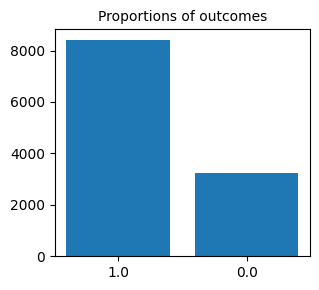

In [59]:
gr.dist_mult_plots(
    df_heart_train,
    cols=[label_col],
		rename_cols_for_title={label_col: 'Proportions of outcomes'},
    figsize=(6, 3),
    ncols=2,
    bar_plot=True,
    fontsize={
        'ax_title': 10,
    },
)

### Features pre-processing

In [60]:
x_train_0, _, y_train_0, _ = lib.pre_process_ecg(
        df_heart_train,
        label_col_pos=-1,
        test_size=base.test_size,
        random_state=base.random_state_test_train_split,
        split_data=False,
				with_lstm_transfo=False,
				for_keras=True,
				n_classes=n_classes,
)

## Visualizations of encoder question 1 representations

You can change the encoder choice in the below cell. The section will run on the encoder selected in the next cell.

In [76]:
encoder = encoder_model_question_1

In [77]:
# Assuming you have already loaded your pre-trained encoder and data
encoded_data = encoder.predict(x_train_0)

364/364 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


In [78]:
# t-SNE
from sklearn.manifold import TSNE

# Initialize t-SNE
tsne = TSNE(n_components=2, random_state=42)

# Fit and transform the data
tsne_results = tsne.fit_transform(encoded_data)

In [79]:
# Umap
import umap.umap_ as umap

# Initialize UMAP
umap_reducer = umap.UMAP(n_components=2, random_state=42)

# Fit and transform the data
umap_results = umap_reducer.fit_transform(encoded_data)

/home/pinolej/.venv_2/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


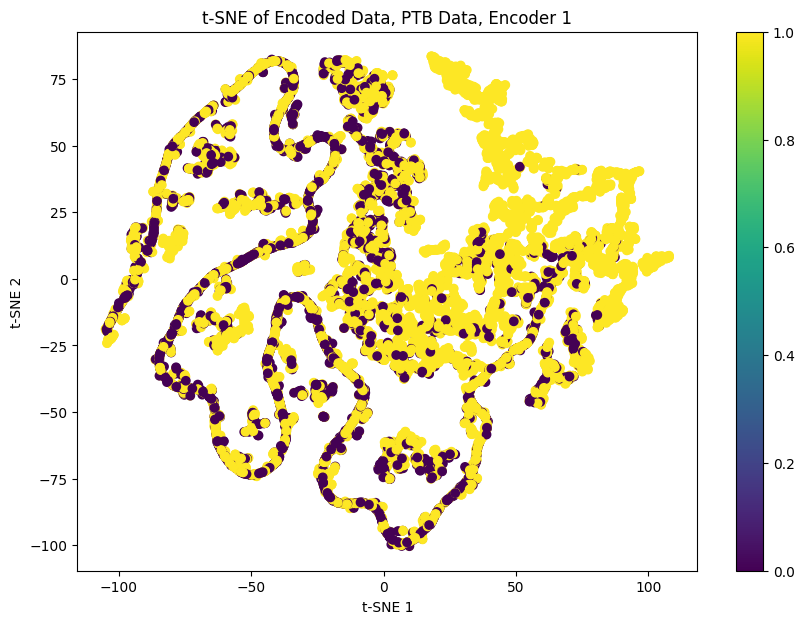

In [82]:
# For t-SNE results
plt.figure(figsize=(10, 7))
plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=labels_values, cmap='viridis') # labels is your data labels if available
plt.colorbar()
plt.title('t-SNE of Encoded Data, PTB Data, Encoder 1')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.show()

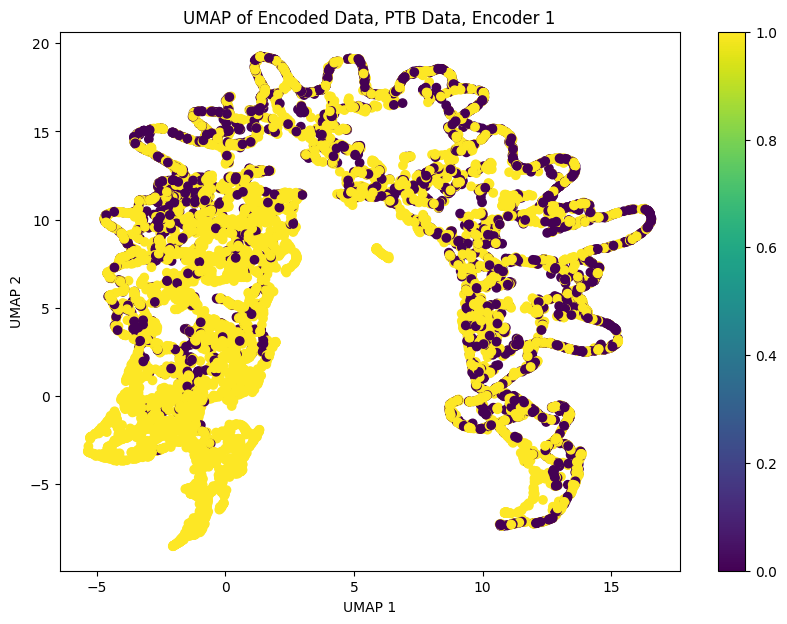

In [83]:
# For UMAP results
plt.figure(figsize=(10, 7))
plt.scatter(umap_results[:, 0], umap_results[:, 1], c=labels_values, cmap='viridis') # labels is your data labels if available
plt.colorbar()
plt.title('UMAP of Encoded Data, PTB Data, Encoder 1')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.show()

## Visualizations of encoder question 2 representations

You can change the encoder choice in the below cell. The section will run on the encoder selected in the next cell.

In [67]:
encoder = encoder_model_question_2

In [68]:
# Assuming you have already loaded your pre-trained encoder and data
encoded_data = encoder.predict(x_train_0)

364/364 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step


In [69]:
# t-SNE
from sklearn.manifold import TSNE

# Initialize t-SNE
tsne = TSNE(n_components=2, random_state=42)

# Fit and transform the data
tsne_results = tsne.fit_transform(encoded_data)

In [70]:
# Umap
import umap.umap_ as umap

# Initialize UMAP
umap_reducer = umap.UMAP(n_components=2, random_state=42)

# Fit and transform the data
umap_results = umap_reducer.fit_transform(encoded_data)

/home/pinolej/.venv_2/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


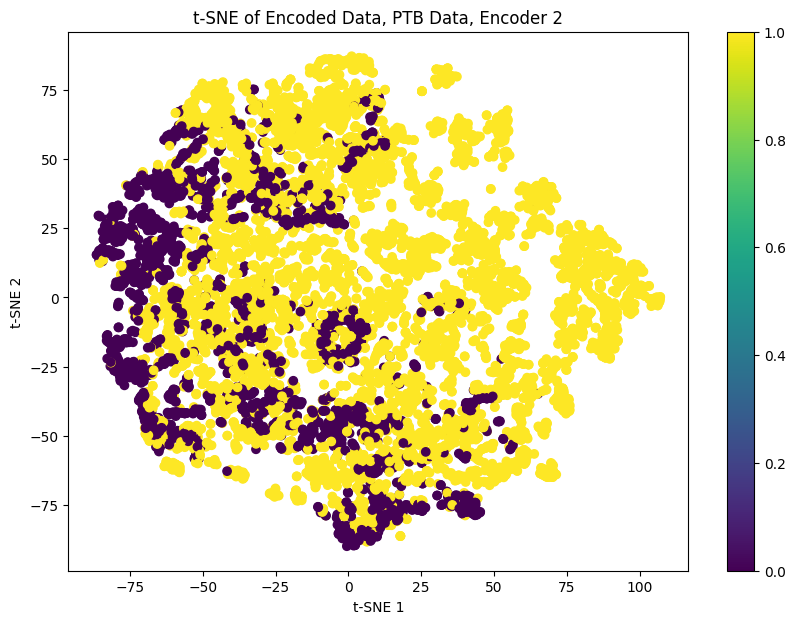

In [73]:
# For t-SNE results
plt.figure(figsize=(10, 7))
plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=labels_values, cmap='viridis') # labels is your data labels if available
plt.colorbar()
plt.title('t-SNE of Encoded Data, PTB Data, Encoder 2')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.show()

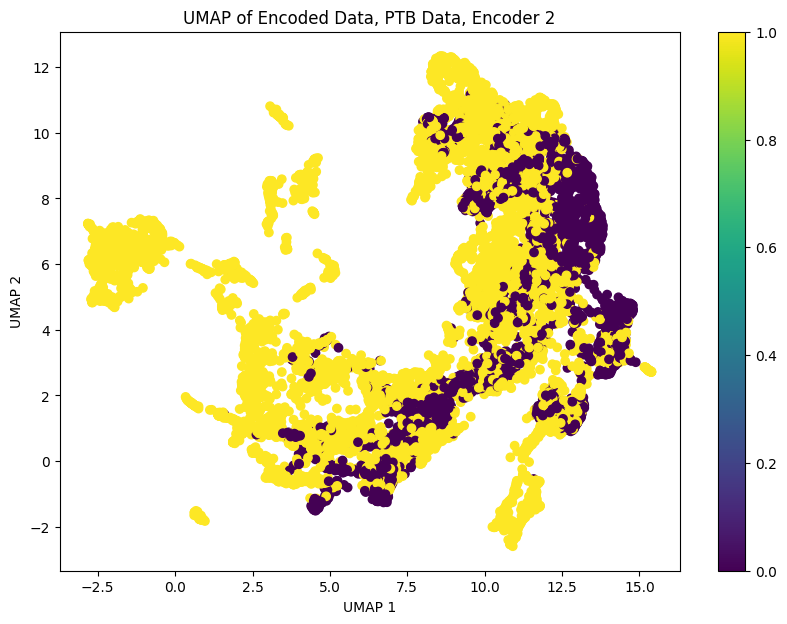

In [74]:
# For UMAP results
plt.figure(figsize=(10, 7))
plt.scatter(umap_results[:, 0], umap_results[:, 1], c=labels_values, cmap='viridis') # labels is your data labels if available
plt.colorbar()
plt.title('UMAP of Encoded Data, PTB Data, Encoder 2')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.show()